In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import seaborn as sns
from io import StringIO  
from IPython.display import Image  
import pydotplus

In [76]:
df = pd.read_csv('clean_df.csv')

In [87]:
matrix = df.corr()

In [93]:
matrix.loc['Sixth_Month_User']

city                     -0.166180
trips_in_first_30_days    0.210463
avg_rating_of_driver     -0.041082
avg_surge                -0.003333
phone                    -0.225834
surge_pct                 0.011797
ultimate_black_user       0.205002
weekday_pct               0.009693
avg_dist                 -0.092780
avg_rating_by_driver     -0.026748
days_active               0.778522
days_inactive            -0.780837
Sixth_Month_User          1.000000
Name: Sixth_Month_User, dtype: float64

None of our variables are highly correlated with whether a customer is active in their sixth month. However, the highest correlations seem to be between what phone the user has (perhaps a UX issue?), how many trips they took in the first 30 days, and whether they are an ultimate black user.

It might be worth considering how to incentive customers to ride more in the first 30 days or use ultimate black, though it seems unlikely the use of ultimate black or more rides in the first 30 days are what cause the person to stay active longer.

## Trees

In [41]:
from sklearn.model_selection import train_test_split

In [77]:
y = df['Sixth_Month_User']
X = df.drop(columns = ['Sixth_Month_User', 'signup_date', 'last_trip_date','days_active','days_inactive']) 

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 22)

In [45]:
from sklearn.linear_model import LogisticRegression

In [150]:
#Logistic Regression Model
pipe = make_pipeline(StandardScaler(), LogisticRegression())
lr_model = pipe.fit(X_train, y_train)
predictions = lr_model.predict(X_test)
print(f"Accuracy equals {metrics.accuracy_score(y_test, predictions)}")
print(f"F1 score equals {metrics.f1_score(y_test, predictions)}")
print(f"Precision: %.2f percent" % (metrics.precision_score(y_test, predictions)*100) )
print(f"Recall: %.2f percent" % (metrics.recall_score(y_test, predictions)*100) )

Accuracy equals 0.69688
F1 score equals 0.5130445958103071
Precision: 64.39 percent
Recall: 42.64 percent


In [151]:
#Random Forest Model
pipe2 = make_pipeline(StandardScaler(), RandomForestClassifier())
rf_model = pipe2.fit(X_train, y_train)
predictions = rf_model.predict(X_test)
print(f"Accuracy equals {metrics.accuracy_score(y_test, predictions)}")
print(f"Precision: %.2f percent" % (metrics.precision_score(y_test, predictions)*100) )
print(f"Recall: %.2f percent" % (metrics.recall_score(y_test, predictions)*100) )

Accuracy equals 0.76392
Precision: 69.36 percent
Recall: 66.20 percent


## PCA

In [100]:
from sklearn.decomposition import PCA

In [96]:
y = df['Sixth_Month_User']
X = df.drop(columns = ['Sixth_Month_User', 'signup_date', 'last_trip_date','days_active','days_inactive']) 

In [98]:
scaled_X = StandardScaler().fit_transform(X)

In [101]:
X_pca = PCA().fit(scaled_X)

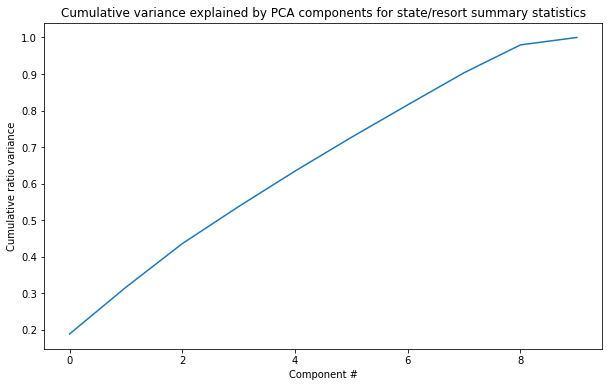

In [103]:
plt.subplots(figsize=(10, 6))
plt.plot(X_pca.explained_variance_ratio_.cumsum())
plt.xlabel('Component #')
plt.ylabel('Cumulative ratio variance')
plt.title('Cumulative variance explained by PCA components for state/resort summary statistics');

In [104]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(scaled_X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [106]:
PCA_df = pd.concat([principalDf, df['Sixth_Month_User']], axis = 1)

In [113]:
PCA_df.head()

,principal component 1,principal component 2,Sixth_Month_User
0,0.317575,-0.112864,1.0
1,-0.427801,-1.406749,0.0
2,-0.446085,0.362475,0.0
3,0.435916,0.674565,1.0
4,0.478187,1.491071,0.0


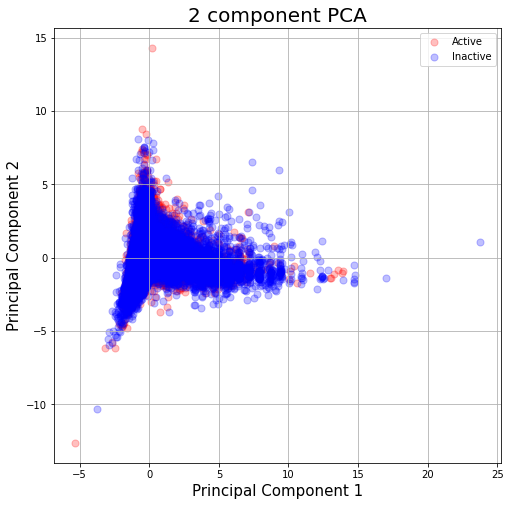

In [129]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [1.0, 0.0]
colors = ['r', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = PCA_df['Sixth_Month_User'] == target
    ax.scatter(PCA_df.loc[indicesToKeep, 'principal component 1']
               , PCA_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50
               , alpha = .25)
ax.legend(['Active', 'Inactive'])
ax.grid()

## XGboost

In [131]:
pip install xgboost

In [132]:
from xgboost import XGBClassifier

In [133]:
model = XGBClassifier()
model.fit(X_train, y_train)
print(model)

C:\Users\sethe\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:01:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=2,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


In [149]:
predictions = model.predict(X_test)
print(f"Accuracy: %.2f percent" % (metrics.accuracy_score(y_test, predictions)*100) )
print(f"Precision: %.2f percent" % (metrics.precision_score(y_test, predictions)*100) )
print(f"Recall: %.2f percent" % (metrics.recall_score(y_test, predictions)*100) )

Accuracy: 79.01 percent
Precision: 74.71 percent
Recall: 66.44 percent


In [135]:
metrics.roc_auc_score(y_test, predictions)

0.7648579991786505

## Conclusion

Unfortunately, there are no easy and clear actions to be taken to improve retention. The correlation between any of the data features given and being active on a user's sixth month are fairly weak.

A visualiztion of the PCA reveals that it is only as our feautures get towards 6+ that we can account for a significant amount of our variance.

What we were able to produce was an XG Boost model that performed with 79% accuracy and nearly 75% precision. With further analysis using this model, perhaps we could work to identify or visualize a customer profiles that are more likely to stay.